La importancia de reducir el riesgo crediticio ha llevado a una institución financiera alemana a buscar soluciones innovadoras. Como científicos de datos, hemos sido convocados para construir un modelo de machine learning preciso y confiable que sea capaz de evaluar con mayor precisión la probabilidad de incumplimiento crediticio de sus clientes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report


# 1. Preprocesamiento de Datos

#**Descripción de Variables del Dataset de Credit Scoring**

- **status**: Estado del crédito, indicando la situación actual del mismo.
- **seniority**: Años de experiencia laboral del solicitante.
- **home**: Tipo de vivienda del solicitante.
- **time**: Plazo del préstamo en meses.
- **age**: Edad del solicitante.
- **marital**: Estado civil del solicitante.
- **records**: Historial de créditos previos del solicitante.
- **job**: Tipo de trabajo o categoría ocupacional.
- **expenses**: Gastos mensuales reportados.
- **income**: Ingresos mensuales del solicitante.
- **assets**: Valor de los ahorros o activos.
- **debt**: Obligaciones financieras actuales.
- **amount**: Monto solicitado en el préstamo.
- **price**: Prima o valor total a devolver por el crédito.


In [3]:
# load dataset of credit scoring

Xfiles = pd.read_csv("CreditRisk.csv")  # read CSV with pandas read_csv
data = Xfiles.copy()                    # copy dataset
data.head(10)                       # look with Head()


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910
5,ok,1,owner,60,36,married,no,fixed,75,214,3500,0,650,1645
6,ok,29,owner,60,44,married,no,fixed,75,125,10000,0,1600,1800
7,ok,9,parents,12,27,single,no,fixed,35,80,0,0,200,1093
8,ok,0,owner,60,32,married,no,freelance,90,107,15000,0,1200,1957
9,default,0,parents,48,41,married,no,partime,90,80,0,0,1200,1468


In [4]:
# Look duplicated

duplicadas = data[data.duplicated(keep=False)]
duplicadas


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
1021,default,5,owner,60,36,married,no,freelance,90,62,3000,0,650,1295
1022,default,5,owner,60,36,married,no,freelance,90,62,3000,0,650,1295
2928,ok,4,owner,60,37,married,no,freelance,35,128,18000,0,800,1560
2929,ok,4,owner,60,37,married,no,freelance,35,128,18000,0,800,1560


In [5]:

print("There are ", data.duplicated().sum(), "duplicate valors in the dataset ")

There are  2 duplicate valors in the dataset 


In [6]:
# Drop row duplicated
data_within_duplicated = data.drop_duplicates()

print(data.shape)
print(data_within_duplicated.shape)
print(data_within_duplicated.duplicated().sum())

(4455, 14)
(4453, 14)
0


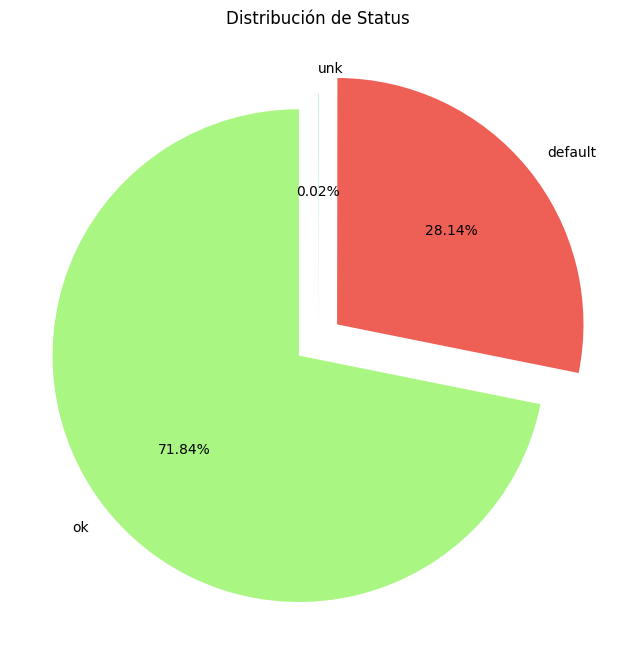

In [7]:
# Count the frequencies of each value in the 'status' column

status_counts = data_within_duplicated['status'].value_counts()   

# Create the cake diagram

colores = ["#AAF683","#EE6055","#60D394","#FFD97D","#FF9B85"]
desfase = (0.1, 0.1, 0)
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.2f%%', startangle=90, colors=colores, explode=desfase)
plt.title('Distribución de Status')
plt.show()


## 1.1 Formato de la columna Default

In [8]:
data_within_duplicated.status.unique()

array(['ok', 'default', 'unk'], dtype=object)

In [9]:
Columna_default = data_within_duplicated.status.value_counts()
Columna_default 

status
ok         3199
default    1253
unk           1
Name: count, dtype: int64

In [10]:
# We see the row that contains the UNK value to analyze and send it to OK or default
unk = data_within_duplicated[data_within_duplicated.status == 'unk']
unk


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
3309,unk,10,private,60,25,single,no,fixed,35,148,3000,0,1500,1888


In [11]:
data_treatment = data_within_duplicated.copy()

# Reemplazar 'unk' por 'ok' en la columna 'status' , Because home is private and amount 1500
data_treatment['status'] = data_treatment['status'].replace('unk', 'ok')

In [12]:
# Crear una nueva columna binaria: 0 para 'ok', 1 para 'default'
data_treatment['default'] = data_treatment['status'].apply(lambda x: 1 if x == 'default' else 0)
data_treatment.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [13]:
data_treatment.drop('status', axis=1, inplace=True)
data_treatment.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [14]:
# Mostrar el conteo de la columna 'default' con formato

default_counts = data_treatment['default'].value_counts().reset_index()
default_counts.columns = ['default','count']
print(default_counts)


   default  count
0        0   3200
1        1   1253


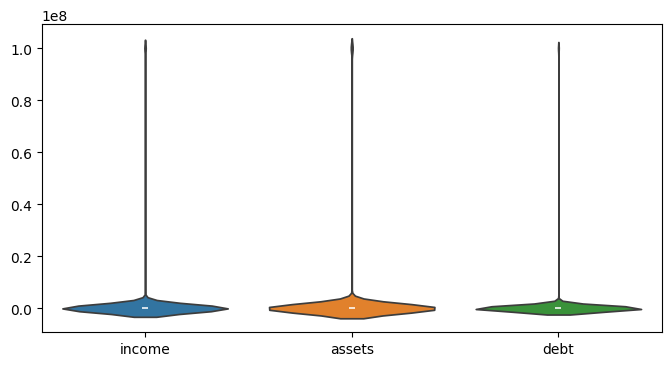

In [15]:
# Crear un gráfico de violín para las tres variables
plt.figure(figsize=(8, 4))
sns.violinplot(data=data_treatment[['income', 'assets', 'debt']])

# Mostrar el gráfico
plt.show()

## 1.2 Datos anomalos


In [16]:
#Have a little problem with outliers in income, assets and debt values

data_treatment.describe().round(0)

,seniority,time,age,expenses,income,assets,debt,amount,price,default
count,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0
mean,8.0,46.0,37.0,56.0,763660.0,1060812.0,404564.0,1039.0,1463.0,0.0
std,8.0,15.0,11.0,20.0,8705565.0,10219839.0,6345672.0,475.0,628.0,0.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0,0.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1117.0,0.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0,0.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0,1.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0,1.0


In [17]:
outliers = data_treatment[data_treatment.income > 100000]
outliers

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
29,0,unk,48,37,single,no,unk,35,99999999,99999999,99999999,1500,1850,1
393,1,owner,36,52,married,yes,freelance,60,99999999,100000,20000,1500,2340,1
803,6,parents,24,25,single,no,fixed,35,99999999,5000,0,850,1480,0
1306,12,owner,36,41,married,no,freelance,60,99999999,10000,0,1000,2100,0
1420,0,owner,60,36,married,yes,freelance,75,99999999,6000,0,1650,1861,1
1436,5,rent,24,29,married,no,freelance,45,99999999,0,0,800,1197,0
1455,2,owner,36,19,single,yes,freelance,35,99999999,9000,0,500,1100,1
1472,15,owner,60,40,married,yes,freelance,75,99999999,16000,0,1150,1850,0
1534,1,owner,60,39,married,no,freelance,60,99999999,6000,3000,850,1104,1
1543,10,owner,36,43,married,no,freelance,60,99999999,4500,0,1000,1905,1


In [18]:
# We replace the Outliers 999999 Values ​​with NAN values ​​and continue analyzing.

data_treatment.replace(99999999, np.nan, inplace=True)


In [19]:
outliers = data_treatment[data_treatment.income > 100000]
outliers

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default


## 1.3 Imputando Datos

In [20]:
null = data_treatment.isnull().sum()
null

seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
default       0
dtype: int64

In [21]:
# Reemplazar NaN con la mediana solo en columnas numéricas
data_treatment[data_treatment.select_dtypes(include=np.number).columns] = data_treatment.select_dtypes(include=np.number).apply(lambda x: x.fillna(x.median()))



In [22]:
# verify the null and descriptive data
null = data_treatment.isnull().sum()
null

seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
default      0
dtype: int64

In [23]:
# verify the null and descriptive data
data_treatment.describe().round(0)

,seniority,time,age,expenses,income,assets,debt,amount,price,default
count,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0
mean,8.0,46.0,37.0,56.0,131.0,5376.0,342.0,1039.0,1463.0,0.0
std,8.0,15.0,11.0,20.0,86.0,11516.0,1244.0,475.0,628.0,0.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0,0.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1117.0,0.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0,0.0
75%,12.0,60.0,45.0,72.0,164.0,6000.0,0.0,1300.0,1692.0,1.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0,1.0


## 1.4 Descriptivos Numericos

In [24]:
numerics = data_treatment.columns
numerics

Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
       'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'],
      dtype='object')

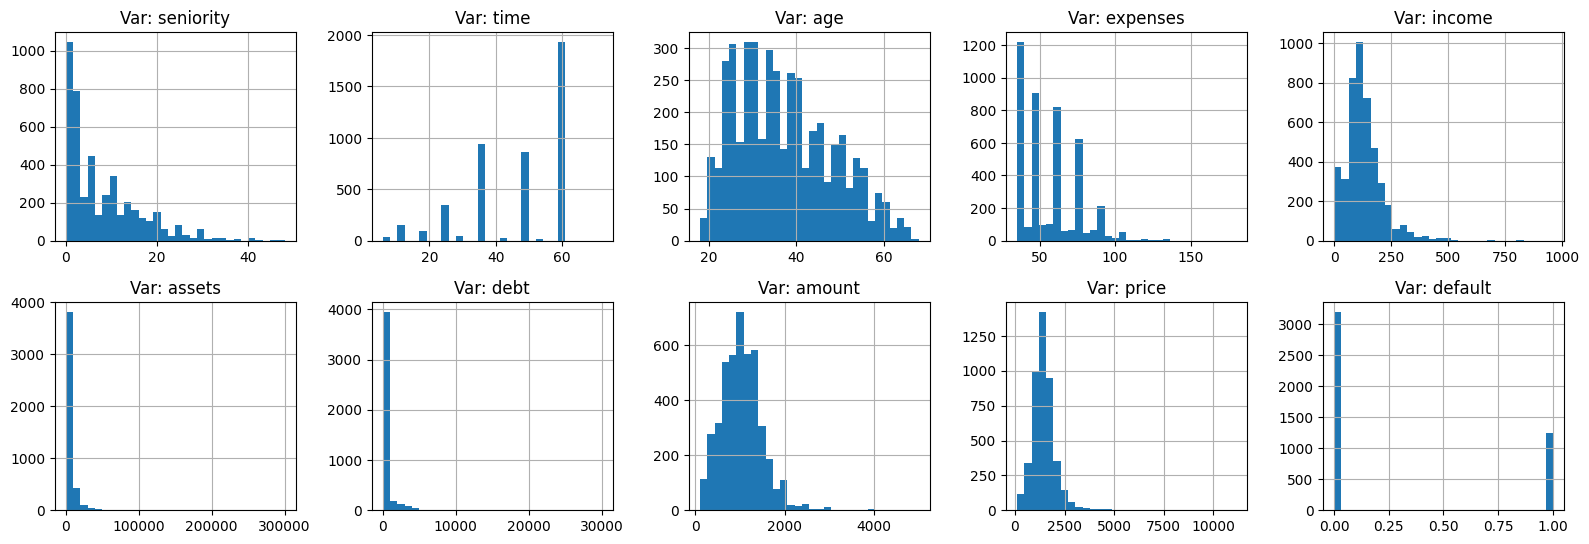

In [25]:
# Seleccionar las columnas numéricas
num_cols = data_treatment.select_dtypes(include=np.number).columns

# Ajustar el tamaño de la cuadrícula según el número de columnas
filas = (len(num_cols) // 5) + 1
columnas = 5

# Crear la figura con subgráficas
fig, axes = plt.subplots(filas, columnas, figsize=(16, 8))
axes = axes.flatten()                                           # Convertir a un arreglo 1D para iterar fácilmente

# Iterar por las columnas numéricas y crear un histograma
for i, col in enumerate(num_cols):
    data_treatment[col].hist(ax=axes[i], bins=30)               # bins=30 ajusta el número de barras
    axes[i].set_title(f"Var: {col}")

# Ocultar las gráficas vacías si hay menos de 10 columnas
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()                                              # Ajustar los márgenes
plt.show()

## 1.5 Truncando valores atipicos

In [26]:
trunc = {'expenses':0.99,'income':0.99,'assets':0.99,'debt':0.99,'amount':0.99,'price':0.99}

In [27]:

for var, perc in trunc.items():
    upper_bound = data_treatment[var].quantile(perc)  # Calcula el percentil 99
    print(f"Se trunca {var} en {upper_bound:.2f}")
    data_treatment[var] = np.clip(data_treatment[var], None, upper_bound)  # Trunca los valores superiores

Se trunca expenses en 106.48
Se trunca income en 428.96
Se trunca assets en 50000.00
Se trunca debt en 4774.00
Se trunca amount en 2500.00
Se trunca price en 3559.48


In [28]:
# Resumen estadístico después del truncamiento
data_treatment.describe().round(0)

,seniority,time,age,expenses,income,assets,debt,amount,price,default
count,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0,4453.0
mean,8.0,46.0,37.0,55.0,129.0,4992.0,304.0,1034.0,1450.0,0.0
std,8.0,15.0,11.0,19.0,80.0,7685.0,875.0,449.0,547.0,0.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0,0.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1117.0,0.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0,0.0
75%,12.0,60.0,45.0,72.0,164.0,6000.0,0.0,1300.0,1692.0,1.0
max,48.0,72.0,68.0,106.0,429.0,50000.0,4774.0,2500.0,3559.0,1.0


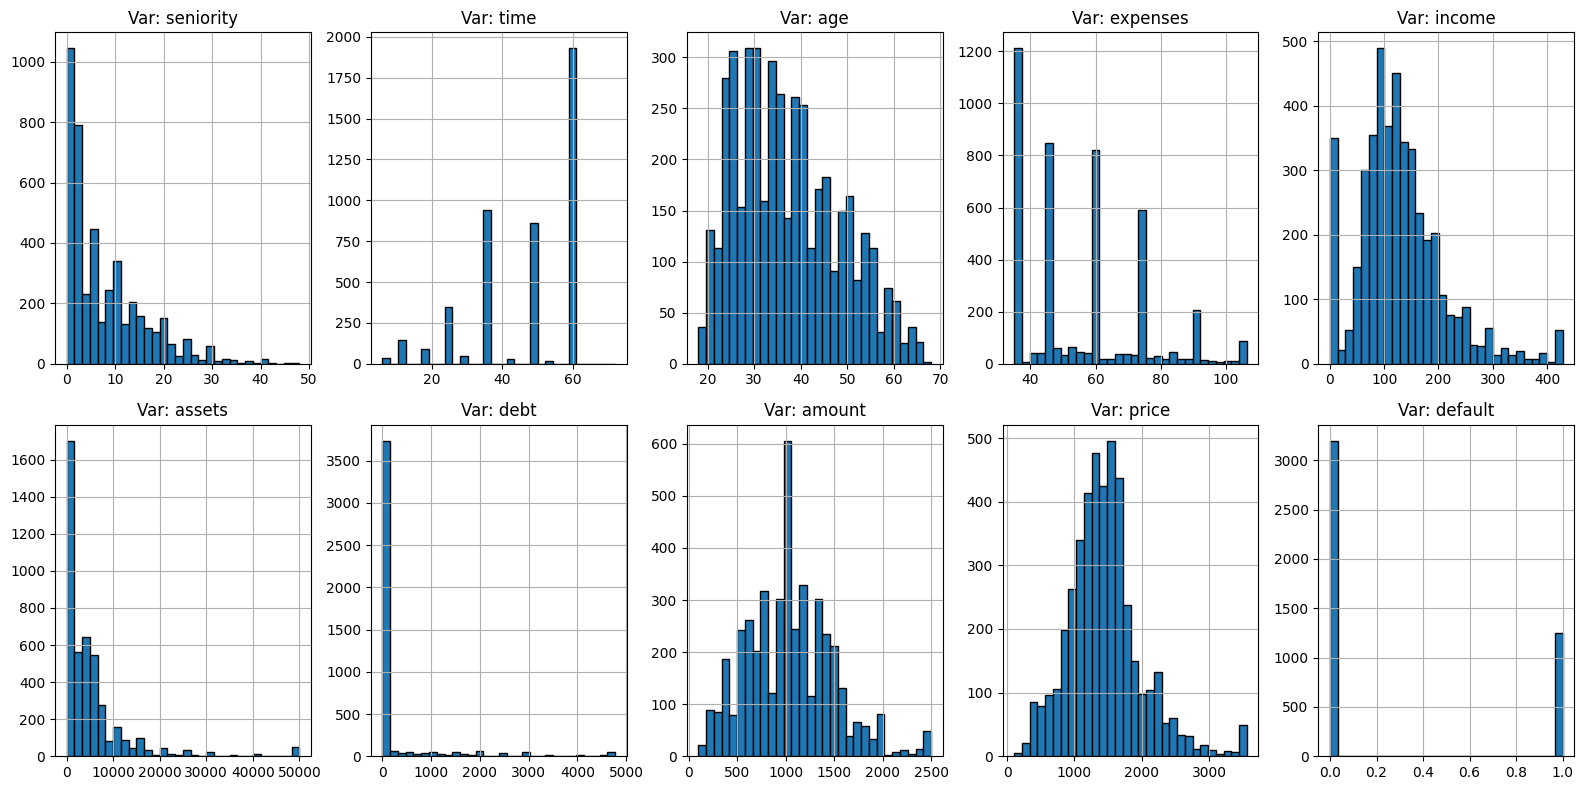

In [29]:
# Visualización de las distribuciones después del truncamiento
num_cols = data_treatment.select_dtypes(include=np.number).columns      # Seleccionar solo columnas numéricas
fig, axes = plt.subplots(2, 5, figsize=(16, 8))                         # Crear una cuadrícula de 2 filas por 5 columnas
ax_flat = axes.flatten()                                                # Aplanar el arreglo de ejes para iterar

for i, col in enumerate(num_cols):
    data_treatment[col].hist(ax=ax_flat[i], bins=30, edgecolor='black')
    ax_flat[i].set_title(f"Var: {col}")

plt.tight_layout()                                                      # Ajusta automáticamente el diseño
plt.show()

## 1.6 Descriptivos Cualitativos

In [30]:
cuali = data_treatment.select_dtypes('object')
cuali.describe()

,home,marital,records,job
count,4453,4453,4453,4453
unique,7,6,2,5
top,owner,married,no,fixed
freq,2105,3239,3680,2806


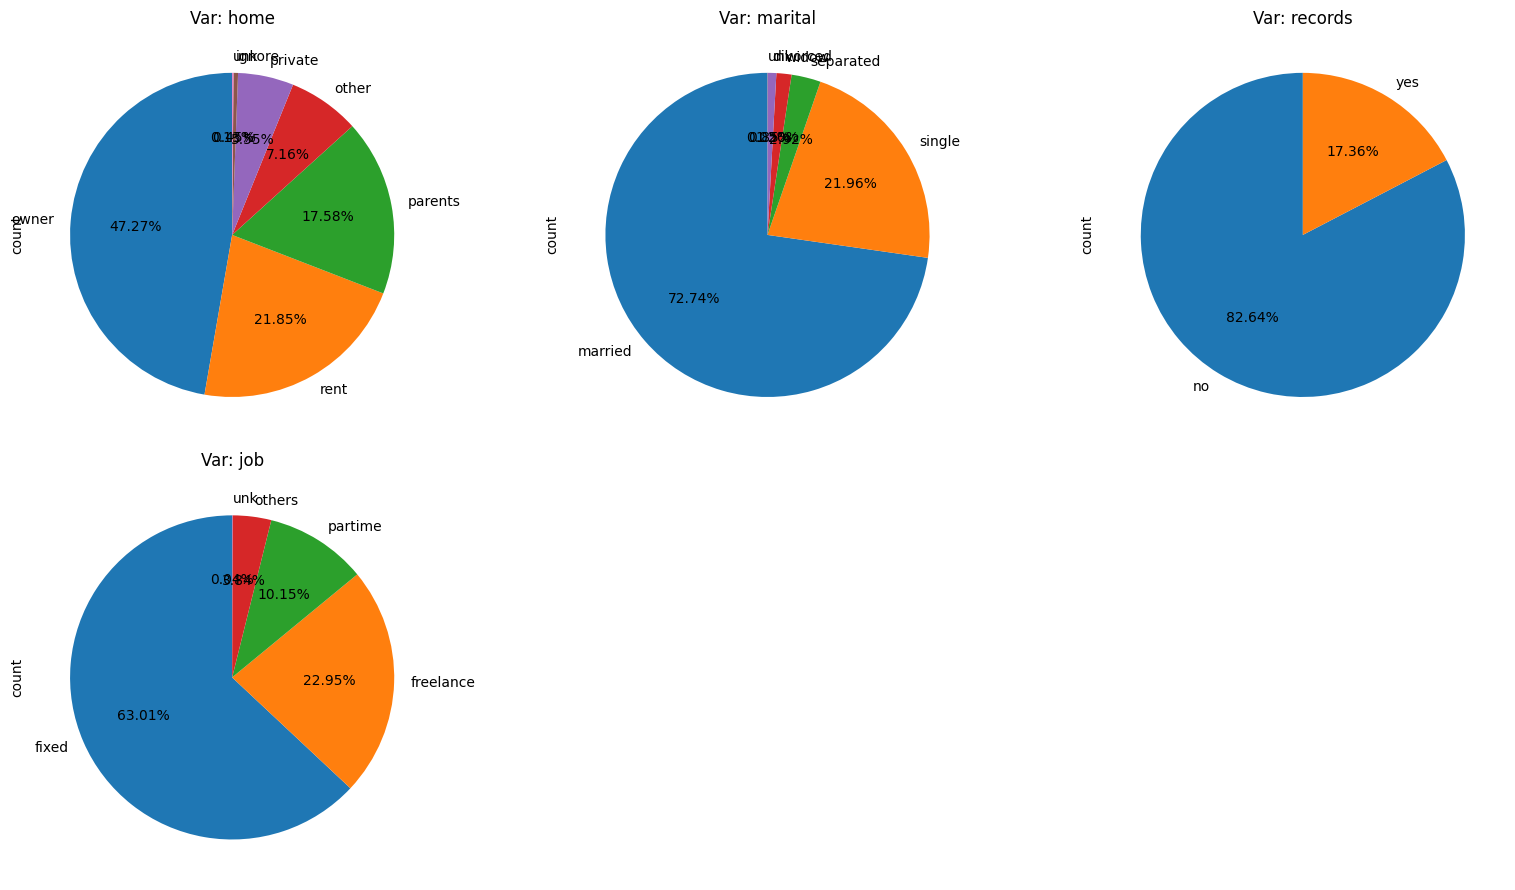

In [31]:
# Seleccionar las columnas categóricas
categorical_cols = data_treatment.select_dtypes(include='object').columns

# Crear el diseño de subgráficas
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

# Generar una gráfica de pastel por cada columna categórica
for i, col in enumerate(categorical_cols):
    data_treatment[col].value_counts().plot.pie(
        ax=axes[i],
        autopct='%1.2f%%',
        startangle=90,
        legend=False,
        title=f"Var: {col}"
    )
    axes[i].set_ylabel('count')  # Etiqueta del eje y

# Ocultar cualquier gráfico adicional si no se usa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 1.7 Reagrupando categorias

In [32]:
# Contar las frecuencias de la columna 'home'
frequency_home = data_treatment['home'].value_counts().reset_index()

# Renombrar las columnas para que coincidan con tu formato
frequency_home.columns = ['home', 'count']
frequency_home

,home,count
0,owner,2105
1,rent,973
2,parents,783
3,other,319
4,private,247
5,ignore,20
6,unk,6


Column Home

In [33]:
frecuencia_home = data_treatment['home'].value_counts(normalize=True).reset_index()
frecuencia_home.columns = ['home', 'proporcion']
umbral = 0.05

# Filtrar las categorías menos representativas
low_frequency = frecuencia_home[frecuencia_home['proporcion'] < umbral]
low_frequency

,home,proporcion
5,ignore,0.004491
6,unk,0.001347


In [34]:
# Reemplazar 'ignore' y 'unk' por 'other'
data_treatment['home'] = data_treatment['home'].replace(['ignore', 'unk'], 'other')
freq_mari = data_treatment['home'].value_counts().reset_index()
freq_mari.columns = ['home', 'count']
freq_mari

,home,count
0,owner,2105
1,rent,973
2,parents,783
3,other,345
4,private,247


Column Marital

In [35]:
# Contar las frecuencias de la columna 'home'
frequency_marital = data_treatment['marital'].value_counts().reset_index()

# Renombrar las columnas para que coincidan con tu formato
frequency_marital.columns = ['marital', 'count']
frequency_marital    

,marital,count
0,married,3239
1,single,978
2,separated,130
3,widow,67
4,divorced,38
5,unk,1


In [36]:
frecuencia_marital = data_treatment['marital'].value_counts(normalize=True).reset_index()
frecuencia_marital.columns = ['marital', 'proporcion']
umbral = 0.05

# Filtrar las categorías menos representativas
low_frequency_m = frecuencia_marital[frecuencia_marital['proporcion'] < umbral]
low_frequency_m

,marital,proporcion
2,separated,0.029194
3,widow,0.015046
4,divorced,0.008534
5,unk,0.000225


In [37]:
# Reemplazar 'ignore' y 'unk' por 'other'
data_treatment['marital'] = data_treatment['marital'].replace(['separated', 'widow','divorced', 'unk'], 'other')
freq_marital = data_treatment['marital'].value_counts().reset_index()
freq_marital.columns = ['marital', 'count']
freq_marital

,marital,count
0,married,3239
1,single,978
2,other,236


Column Job

In [38]:
# Contar las frecuencias de la columna 'job'
frequency_job = data_treatment['job'].value_counts().reset_index()

# Renombrar las columnas para que coincidan con tu formato
frequency_job.columns = ['job', 'count']
frequency_job

,job,count
0,fixed,2806
1,freelance,1022
2,partime,452
3,others,171
4,unk,2


In [39]:
frecuencia_job = data_treatment['job'].value_counts(normalize=True).reset_index()
frecuencia_job.columns = ['job', 'proporcion']
umbral = 0.05

# Filtrar las categorías menos representativas
low_frequency_job = frecuencia_job[frecuencia_job['proporcion'] < umbral]
low_frequency_job

,job,proporcion
3,others,0.038401
4,unk,0.000449


In [40]:
# Reemplazar 'ignore' y 'unk' por 'other'
data_treatment['job'] = data_treatment['job'].replace(['other'], 'others')
freq_job = data_treatment['job'].value_counts().reset_index()
freq_job.columns = ['job', 'count']
freq_job

,job,count
0,fixed,2806
1,freelance,1022
2,partime,452
3,others,171
4,unk,2


## 1.8 Eliminando columnas

# **2. Exploración de Datos**

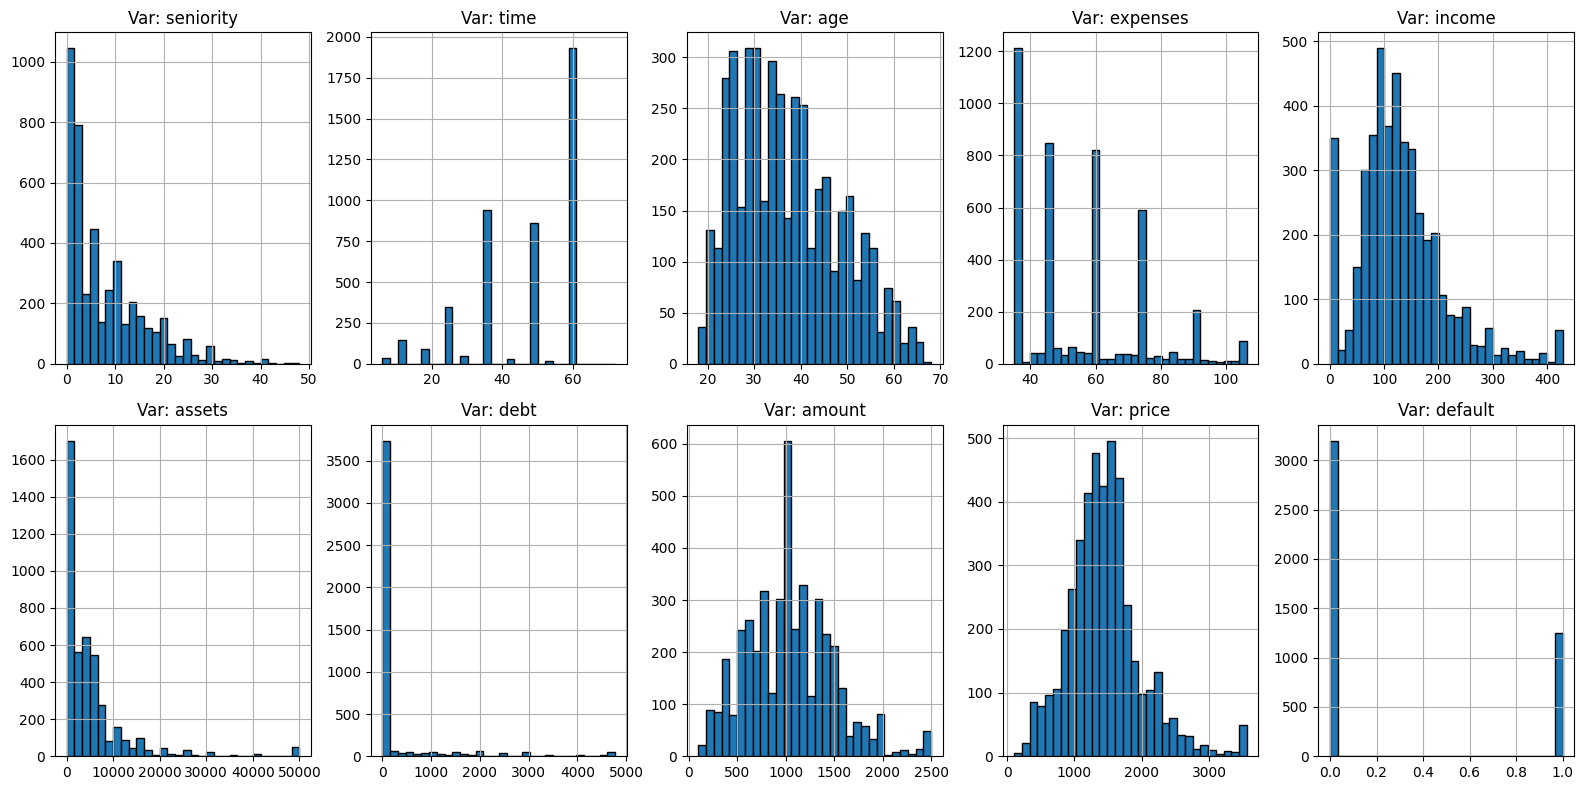

In [41]:
# Visualización de las distribuciones después del truncamiento
num_cols = data_treatment.select_dtypes(include=np.number).columns      # Seleccionar solo columnas numéricas
fig, axes = plt.subplots(2, 5, figsize=(16, 8))                         # Crear una cuadrícula de 2 filas por 5 columnas
ax_flat = axes.flatten()                                                # Aplanar el arreglo de ejes para iterar

for i, col in enumerate(num_cols):
    data_treatment[col].hist(ax=ax_flat[i], bins=30, edgecolor='black')
    ax_flat[i].set_title(f"Var: {col}")

plt.tight_layout()                                                      # Ajusta automáticamente el diseño
plt.show()

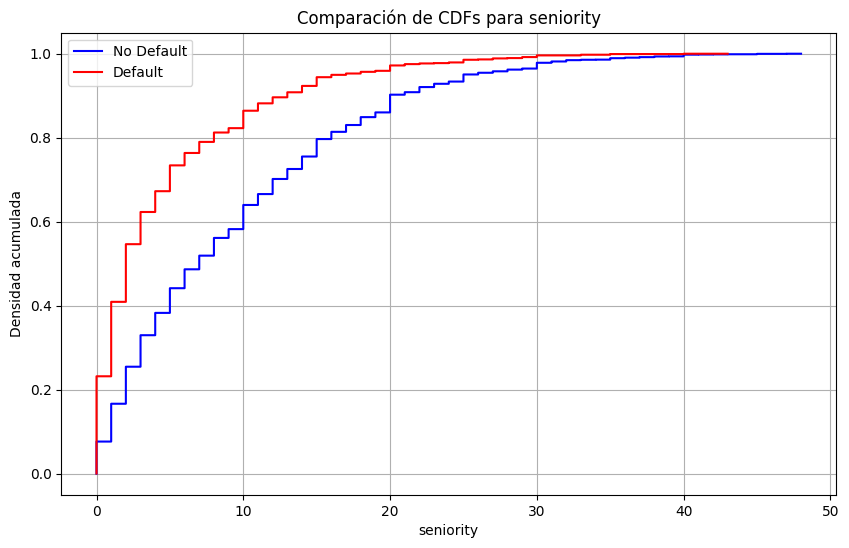

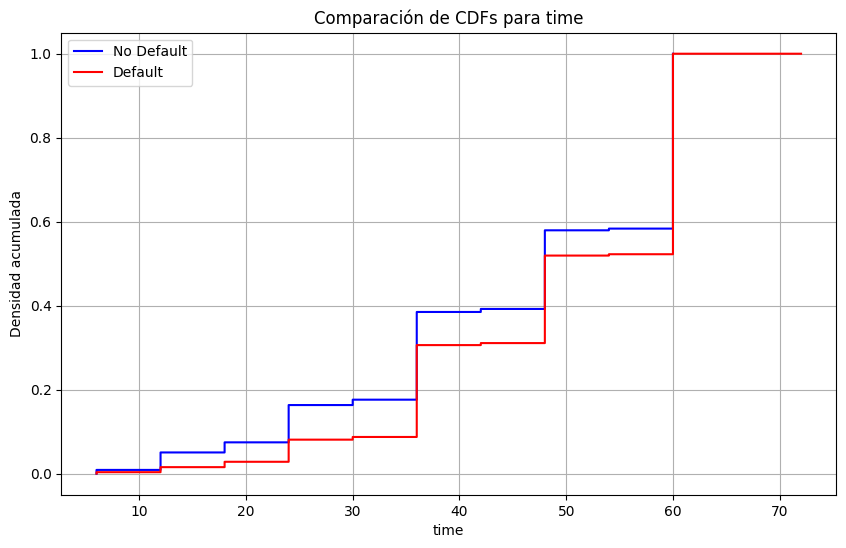

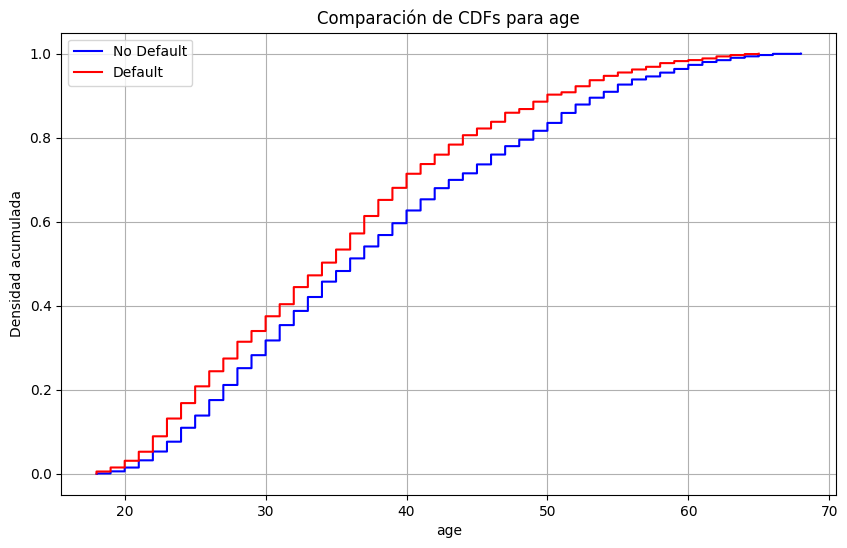

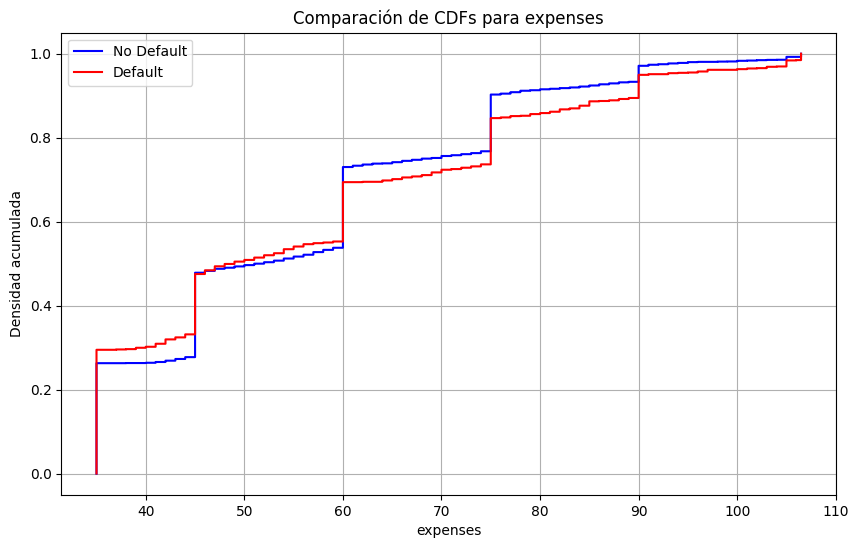

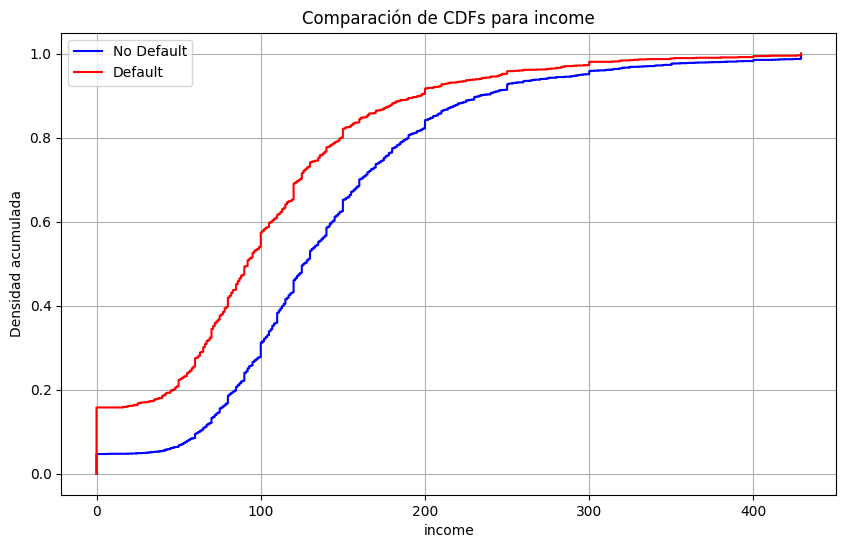

In [42]:
# Variables a analizar
variables = ['seniority', 'time', 'age', 'expenses', 'income']

# Crear gráficos de CDF para cada variable
for var in variables:
    plt.figure(figsize=(10, 6))
    plt.title(f'Comparación de CDFs para {var}')
    plt.xlabel(var)
    plt.ylabel('Densidad acumulada')

    # Separar por Default y No Default
    for label, color in zip([0, 1], ['blue', 'red']):
        data = data_treatment[data_treatment['default'] == label][var]
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        plt.step(sorted_data, cdf, color=color, label='No Default' if label == 0 else 'Default')

    plt.legend()
    plt.grid(True)
    plt.show()


## 2.2 Datos Cualitativos

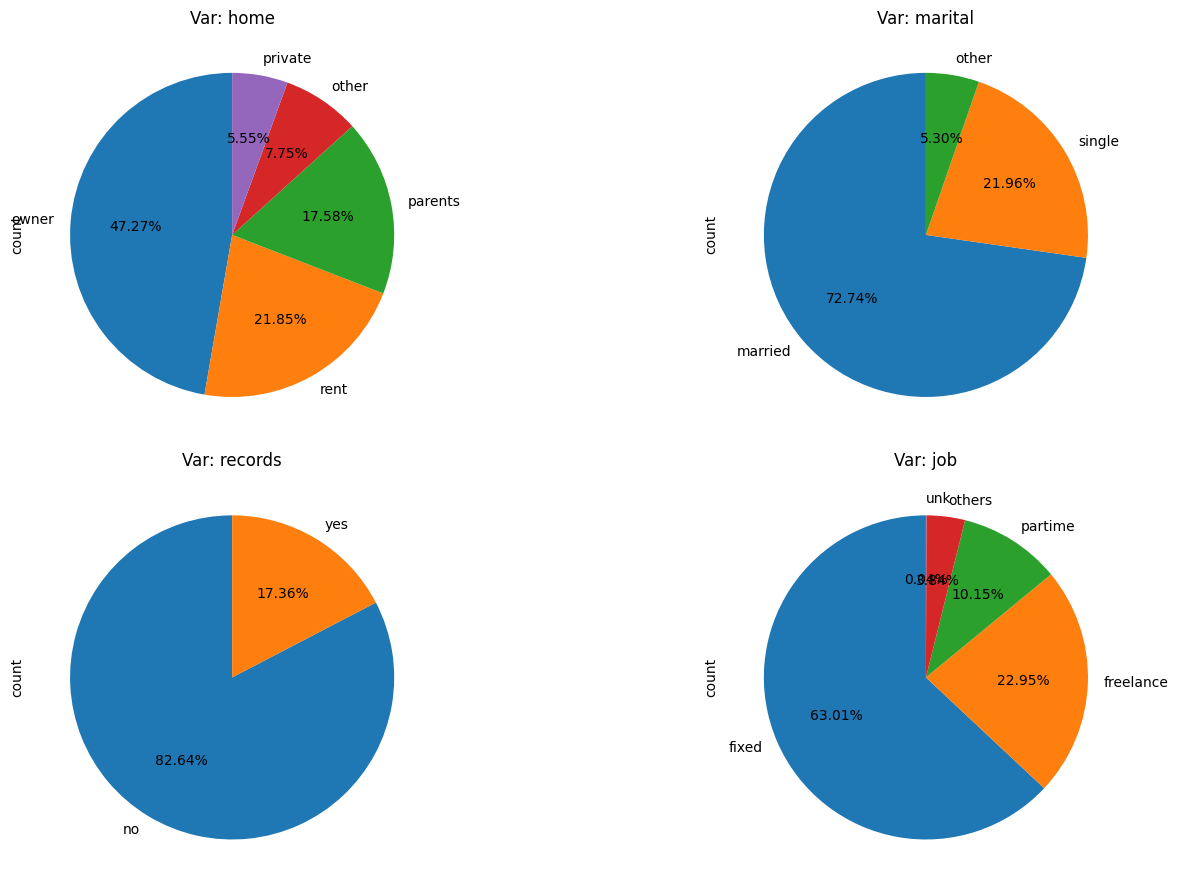

In [43]:
# Seleccionar las columnas categóricas
categorical_cols = data_treatment.select_dtypes(include='object').columns

# Crear el diseño de subgráficas
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

# Generar una gráfica de pastel por cada columna categórica
for i, col in enumerate(categorical_cols):
    data_treatment[col].value_counts().plot.pie(
        ax=axes[i],
        autopct='%1.2f%%',
        startangle=90,
        legend=False,
        title=f"Var: {col}"
    )
    axes[i].set_ylabel('count')  # Etiqueta del eje y

# Ocultar cualquier gráfico adicional si no se usa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2.3 Contribucion al riesgo

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12900\3506748801.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_relativo.index, y=riesgo_relativo.values, palette='coolwarm', alpha=0.7)


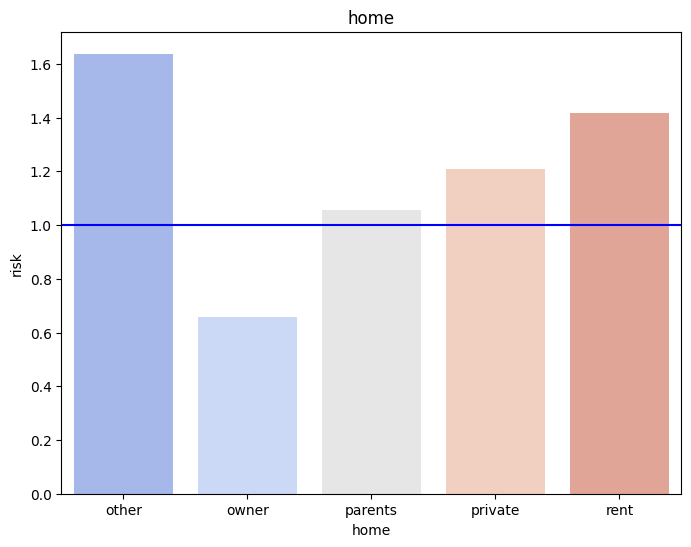

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12900\3506748801.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_relativo.index, y=riesgo_relativo.values, palette='coolwarm', alpha=0.7)


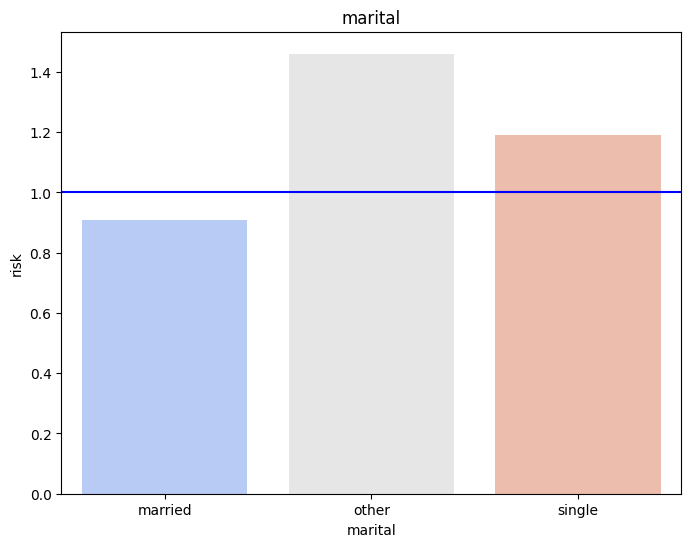

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12900\3506748801.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_relativo.index, y=riesgo_relativo.values, palette='coolwarm', alpha=0.7)


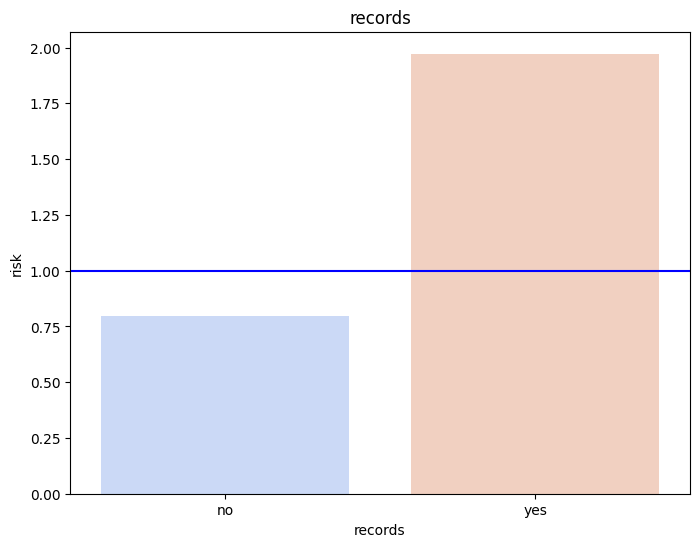

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12900\3506748801.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=riesgo_relativo.index, y=riesgo_relativo.values, palette='coolwarm', alpha=0.7)


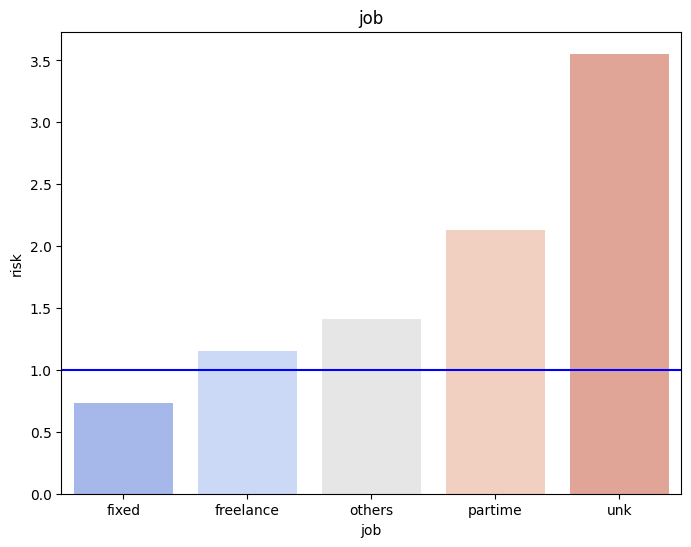

In [44]:
# Función para calcular el riesgo relativo
def calcular_riesgo(data_treatment, variable, target='default'):
    riesgo = data_treatment.groupby(variable)[target].mean() / data_treatment[target].mean()
    return riesgo

# Variables categóricas a analizar
categorical_vars = ['home', 'marital', 'records', 'job']

# Generar gráficos de riesgo relativo
for var in categorical_vars:
    riesgo_relativo = calcular_riesgo(data_treatment, var)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=riesgo_relativo.index, y=riesgo_relativo.values, palette='coolwarm', alpha=0.7)
    plt.axhline(1, color='blue')  # Línea de referencia en 1 (riesgo promedio)
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('risk')
    plt.show()


# **3. Construcción de Modelos**

## 3.1 Partición de datos

In [45]:
data_treatment.head(10)

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73.0,129.0,0.0,0.0,800,846.0,0
1,17,rent,60,58,other,no,fixed,48.0,131.0,0.0,0.0,1000,1658.0,0
2,10,owner,36,46,married,yes,freelance,90.0,200.0,3000.0,0.0,2000,2985.0,1
3,0,rent,60,24,single,no,fixed,63.0,182.0,2500.0,0.0,900,1325.0,0
4,0,rent,36,26,single,no,fixed,46.0,107.0,0.0,0.0,310,910.0,0
5,1,owner,60,36,married,no,fixed,75.0,214.0,3500.0,0.0,650,1645.0,0
6,29,owner,60,44,married,no,fixed,75.0,125.0,10000.0,0.0,1600,1800.0,0
7,9,parents,12,27,single,no,fixed,35.0,80.0,0.0,0.0,200,1093.0,0
8,0,owner,60,32,married,no,freelance,90.0,107.0,15000.0,0.0,1200,1957.0,0
9,0,parents,48,41,married,no,partime,90.0,80.0,0.0,0.0,1200,1468.0,1


In [46]:
x = data_treatment.drop(columns='default')
x = pd.get_dummies(x)
y = data_treatment['default']

In [47]:
# Seleccionar las columnas de tipo booleano
boolean_columns = x.select_dtypes(include='bool').columns

# Convertir las columnas booleanas a enteros
x[boolean_columns] = x[boolean_columns].astype(int)

In [48]:
x.head()

,seniority,time,age,expenses,income,assets,debt,amount,price,home_other,...,marital_married,marital_other,marital_single,records_no,records_yes,job_fixed,job_freelance,job_others,job_partime,job_unk
0,9,60,30,73.0,129.0,0.0,0.0,800,846.0,0,...,1,0,0,1,0,0,1,0,0,0
1,17,60,58,48.0,131.0,0.0,0.0,1000,1658.0,0,...,0,1,0,1,0,1,0,0,0,0
2,10,36,46,90.0,200.0,3000.0,0.0,2000,2985.0,0,...,1,0,0,0,1,0,1,0,0,0
3,0,60,24,63.0,182.0,2500.0,0.0,900,1325.0,0,...,0,0,1,1,0,1,0,0,0,0
4,0,36,26,46.0,107.0,0.0,0.0,310,910.0,0,...,0,0,1,1,0,1,0,0,0,0


In [49]:
# Dividir el dataset en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Mostrar las dimensiones de los conjuntos resultantes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (3562, 24)
X_test: (891, 24)
y_train: (3562,)
y_test: (891,)


## 3.2 Modelos de clasificacion

#### Regresion Logistica

#### Ajustar modelo

In [50]:
# =========================================================================
# 1. Entrenar el modelo de Regresión Logística
# =========================================================================
# Tu código aquí
reg_logit = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)

reg_logit.fit(X_train, y_train)
reg_logit  # Muestra la información del modelo entrenado


c:\Users\Lenovo\Documents\DataScience\EnvData\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [51]:
# =========================================================================
# 2. Predicciones y evaluación en el set de prueba
# =========================================================================
# Tu código aquí
clas_logit = reg_logit.predict(X_test)

# Matriz de confusión
print(pd.crosstab(y_test, clas_logit, margins=True))

# Reporte de clasificación
print(classification_report(y_test, clas_logit))

col_0      0    1  All
default               
0        581   42  623
1        152  116  268
All      733  158  891
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       623
           1       0.73      0.43      0.54       268

    accuracy                           0.78       891
   macro avg       0.76      0.68      0.70       891
weighted avg       0.78      0.78      0.76       891



AUC-ROC: 0.83


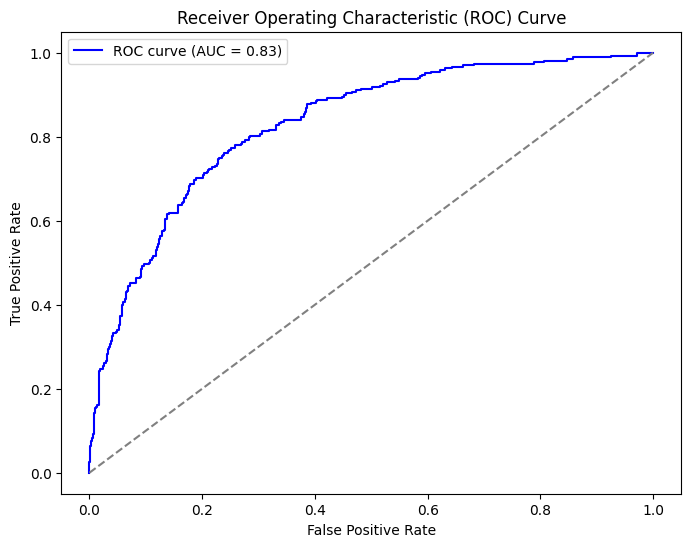

In [52]:
# =========================================================================
# 3. Curva ROC
# =========================================================================
# Predicción de probabilidades
# Tu código aquí
y_pred_proba = reg_logit.predict_proba(X_test)[:, 1]

# Cálculo del AUC-ROC
# Tu código aquí
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc:.2f}')

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [53]:
# =========================================================================
# 4. Predicción inicial (por ejemplo, sobre el set de entrenamiento)
# =========================================================================
# Tu código aquí
clas_logit2 = reg_logit.predict(X_train)

print(pd.crosstab(y_train, clas_logit2, margins=True))
print(classification_report(y_train, clas_logit2))

# =========================================================================
# 5. Función para graficar histograma de scores por Default y No Default
# =========================================================================
def hist_fill_p(y_true, scores, bins=10):
    """
    Grafica dos histogramas superpuestos:
    - scores de las observaciones con y_true == 0 (No Default)
    - scores de las observaciones con y_true == 1 (Default)
    """
    plt.figure(figsize=(8, 6))
    plt.hist(scores[y_true == 0], bins=bins, alpha=0.5, label='No Default')
    plt.hist(scores[y_true == 1], bins=bins, alpha=0.5, label='Default')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities by Default Status')
    plt.legend()
    plt.show()

col_0       0    1   All
default                 
0        2379  198  2577
1         503  482   985
All      2882  680  3562
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2577
           1       0.71      0.49      0.58       985

    accuracy                           0.80      3562
   macro avg       0.77      0.71      0.73      3562
weighted avg       0.79      0.80      0.79      3562



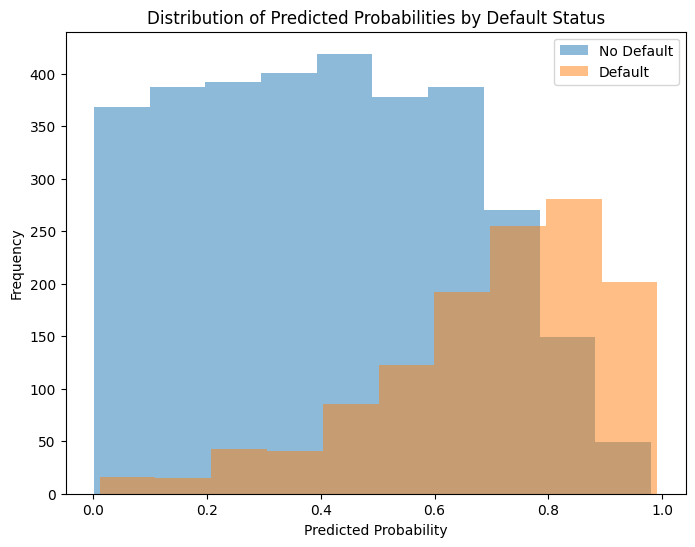

In [54]:
# =========================================================================
# 6. Calcular y graficar el score en todo el DataFrame
# =========================================================================
# Tu código aquí

# 1. Aplica pd.get_dummies a data_treatment
X_treatment = pd.get_dummies(data_treatment.drop(columns=['default']), drop_first=True)

# 2. Asegúrate de que las columnas coincidan con las usadas en el entrenamiento
X_treatment = X_treatment.reindex(columns=X_train.columns, fill_value=0)

# 3. Ahora puedes predecir las probabilidades sin error
data_treatment['score_logit'] = reg_logit.predict_proba(X_treatment)[:, 1]

# Usar la función para graficar
hist_fill_p(data_treatment['default'],data_treatment['score_logit'])


### Modelo Arbol

#### Ajustar modelo

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
# =========================================================================
# 1. Entrenar el modelo de Árbol de Decisión
# =========================================================================
reg_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
reg_tree.fit(X_train, y_train)
reg_tree  # Muestra la información del árbol entrenado

DecisionTreeClassifier(max_depth=5, random_state=42)

In [57]:
# =========================================================================
# 2. Predicciones y evaluación en el set de prueba
# =========================================================================
clas_tree = reg_tree.predict(X_test)

# Matriz de confusión
pd.crosstab(y_test, clas_tree, margins=True)

col_0,0,1,All
default,,,
0,544,79,623
1,151,117,268
All,695,196,891


In [58]:
print(classification_report(y_test, clas_tree))

              precision    recall  f1-score   support

           0       0.78      0.87      0.83       623
           1       0.60      0.44      0.50       268

    accuracy                           0.74       891
   macro avg       0.69      0.65      0.66       891
weighted avg       0.73      0.74      0.73       891



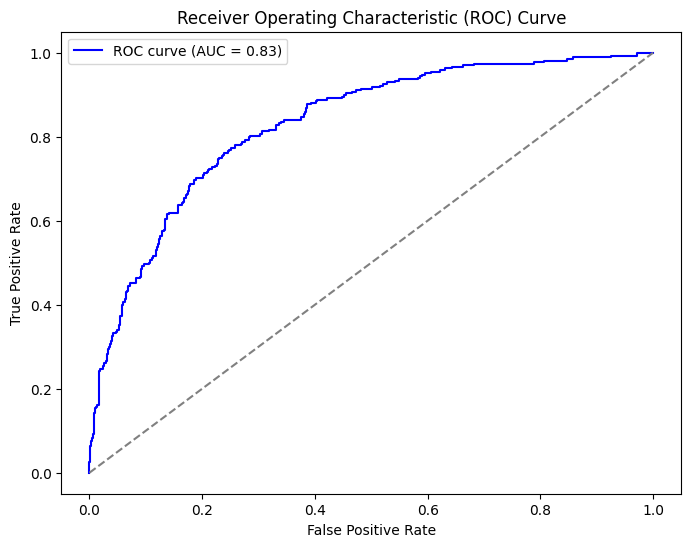

In [59]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [60]:
# =========================================================================
# 4. Predicción en otro conjunto (por ejemplo, el de entrenamiento)
# =========================================================================
clas_tree2 = reg_tree.predict(X_train)

pd.crosstab(y_train, clas_tree2, margins=True)


col_0,0,1,All
default,,,
0,2325,252,2577
1,436,549,985
All,2761,801,3562


In [61]:
print(classification_report(y_train, clas_tree2))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2577
           1       0.69      0.56      0.61       985

    accuracy                           0.81      3562
   macro avg       0.76      0.73      0.74      3562
weighted avg       0.80      0.81      0.80      3562



In [62]:
# =========================================================================
# 5. Función para graficar histograma de scores por Default y No Default
# =========================================================================
def hist_fill_p(y_true, scores, bins=10):
    """
    Grafica dos histogramas superpuestos:
    - scores de las observaciones con y_true == 0 (No Default)
    - scores de las observaciones con y_true == 1 (Default)
    """
    plt.figure(figsize=(8, 6))
    plt.hist(scores[y_true == 0], bins=bins, alpha=0.5, label='No Default')
    plt.hist(scores[y_true == 1], bins=bins, alpha=0.5, label='Default')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities by Default Status')
    plt.legend()
    plt.show()

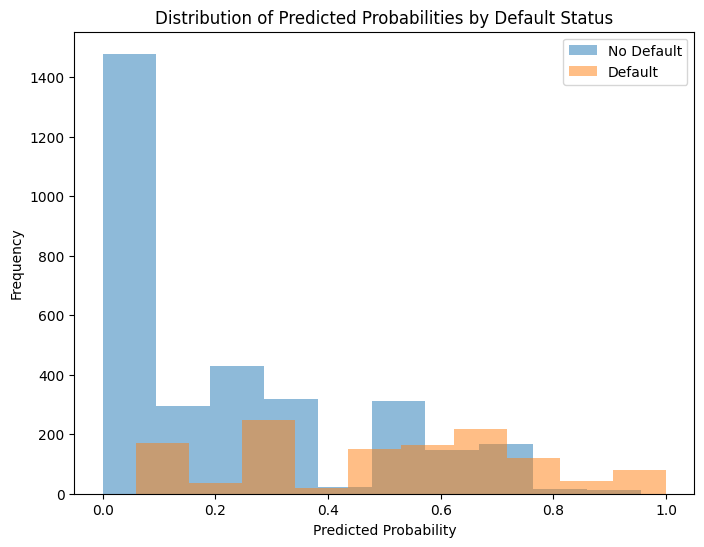

In [63]:
# =========================================================================
# 6. Calcular y graficar el score en todo el DataFrame
# =========================================================================
# Tu código aquí

# Aplica pd.get_dummies a data_treatment
X_treatment_tree = pd.get_dummies(data_treatment.drop(columns=['default']), drop_first=True)

# Asegúrate de que las columnas coincidan con las usadas en el entrenamiento
X_treatment_tree = X_treatment_tree.reindex(columns=X_train.columns, fill_value=0)

# Ahora puedes predecir las probabilidades sin error
data_treatment['score_tree'] = reg_tree.predict_proba(X_treatment_tree)[:, 1]

# Usar la función para graficar
hist_fill_p(data_treatment['default'],data_treatment['score_tree'])

### Modelo Random Forest

#### Ajustar modelo

In [64]:
# =========================================================================
# 1. Entrenar el modelo de Random Forest
# =========================================================================
reg_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
reg_forest.fit(X_train, y_train)
reg_forest  # Muestra información del modelo entrenado

RandomForestClassifier(max_depth=5, random_state=42)

In [65]:
# =========================================================================
# 2. Predicciones y evaluación en el set de prueba
# =========================================================================
clas_forest = reg_forest.predict(X_test)

# Matriz de confusión
pd.crosstab(y_test, clas_forest, margins=True)

col_0,0,1,All
default,,,
0,590,33,623
1,179,89,268
All,769,122,891


In [66]:
print(classification_report(y_test, clas_forest))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       623
           1       0.73      0.33      0.46       268

    accuracy                           0.76       891
   macro avg       0.75      0.64      0.65       891
weighted avg       0.76      0.76      0.73       891



In [67]:
# =========================================================================
# 3. Curva ROC
# =========================================================================
# Predicción de probabilidades (solo la probabilidad de la clase 1)
y_pred_proba = reg_forest.predict_proba(X_test)[:, 1]

In [68]:
# Cálculo del AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc:.2f}')



AUC-ROC: 0.82


In [69]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


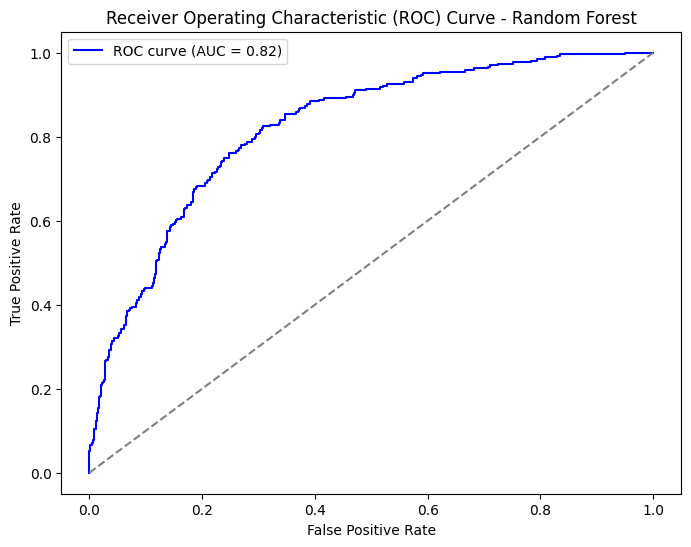

In [70]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend()
plt.show()

In [71]:
# =========================================================================
# 4. (Opcional) Predicción en otro conjunto (por ejemplo, el de entrenamiento)
# =========================================================================
clas_forest2 = reg_forest.predict(X_train)
pd.crosstab(y_train, clas_forest2, margins=True)




col_0,0,1,All
default,,,
0,2484,93,2577
1,577,408,985
All,3061,501,3562


In [72]:

print(classification_report(y_train, clas_forest2))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      2577
           1       0.81      0.41      0.55       985

    accuracy                           0.81      3562
   macro avg       0.81      0.69      0.72      3562
weighted avg       0.81      0.81      0.79      3562



In [73]:
# =========================================================================
# 5. Función para graficar histograma de scores por Default y No Default
# =========================================================================
def hist_fill_p(y_true, scores, bins=10):
    """
    Grafica dos histogramas superpuestos:
    - scores de las observaciones con y_true == 0 (No Default)
    - scores de las observaciones con y_true == 1 (Default)
    """
    plt.figure(figsize=(8, 6))
    plt.hist(scores[y_true == 0], bins=bins, alpha=0.5, label='No Default')
    plt.hist(scores[y_true == 1], bins=bins, alpha=0.5, label='Default')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities by Default Status')
    plt.legend()
    plt.show()

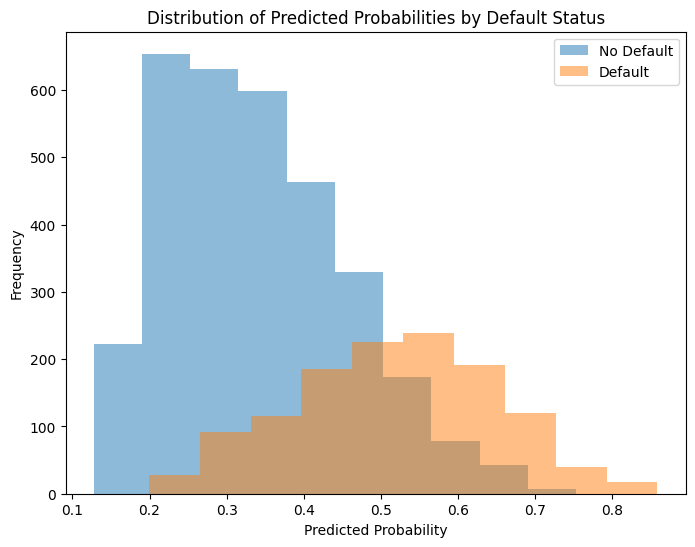

In [74]:
# =========================================================================
# 6. Calcular y graficar el score en todo el DataFrame
# =========================================================================
# Asegúrate de que 'data' tenga las mismas columnas (y transformaciones) 

# Aplica pd.get_dummies a data_treatment
X_treatment_forest = pd.get_dummies(data_treatment.drop(columns=['default']), drop_first=True)

# Asegúrate de que las columnas coincidan con las usadas en el entrenamiento
X_treatment_forest = X_treatment_forest.reindex(columns=X_train.columns, fill_value=0)

# Ahora puedes predecir las probabilidades sin error
data_treatment['score_forest'] = reg_forest.predict_proba(X_treatment_forest)[:, 1]

# Graficar la distribución de los scores
hist_fill_p(data_treatment['default'], data_treatment['score_forest'])

# **4. Evaluación y Selección del Modelo**


In [75]:
# 1) Regresión Logística
class_logit = reg_logit.predict(X_test)
y_pred_proba_logit = reg_logit.predict_proba(X_test)[:, 1]

# 2) Árbol de Decisión
class_tree = reg_tree.predict(X_test)
y_pred_proba_tree = reg_tree.predict_proba(X_test)[:, 1]

# 3) Random Forest
class_forest = reg_forest.predict(X_test)
y_pred_proba_forest = reg_forest.predict_proba(X_test)[:, 1]


In [76]:
def get_metrics(y_true, y_pred, y_prob=None):
    """
    Calcula y devuelve un diccionario con:
    - accuracy
    - precision (macro avg)
    - recall (macro avg)
    - f1-score (macro avg)
    - auc (si se proporciona y_prob)
    """
    # classification_report con formato de diccionario
    report = classification_report(y_true, y_pred, output_dict=True)
    
    metrics = {
        'accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1-score': report['macro avg']['f1-score']
    }
    
    if y_prob is not None:
        metrics['auc'] = roc_auc_score(y_true, y_prob)
    else:
        metrics['auc'] = None
    
    return metrics

In [77]:
metrics_logit = get_metrics(y_test, clas_logit, y_pred_proba_logit)
metrics_tree = get_metrics(y_test, clas_tree, y_pred_proba_tree)
metrics_forest = get_metrics(y_test, clas_forest, y_pred_proba_forest)

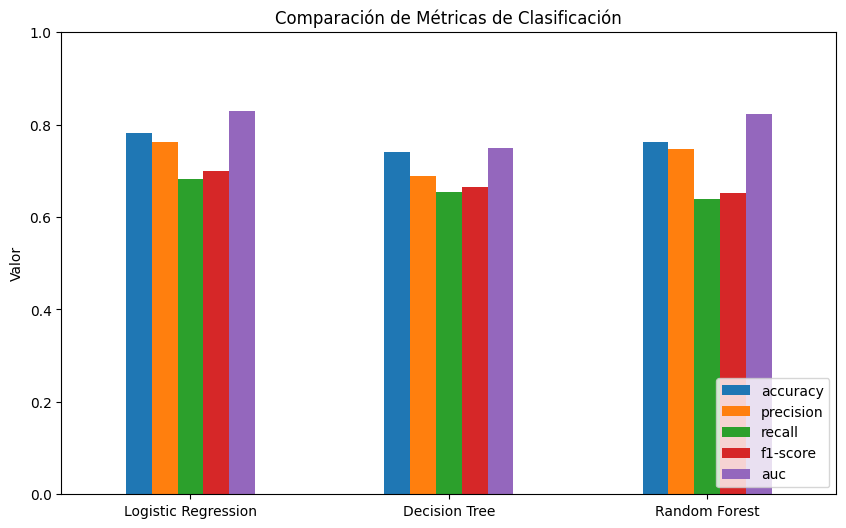

In [ ]:
# Crear un DataFrame donde cada columna es un modelo y cada fila una métrica
df_compare = pd.DataFrame({
    'Logistic Regression': metrics_logit,
    'Decision Tree': metrics_tree,
    'Random Forest': metrics_forest
})

# Transponer para que las filas sean los modelos y las columnas las métricas
df_compare = df_compare.transpose()

# Graficar en barras
ax = df_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Métricas de Clasificación')
plt.ylabel('Valor')
plt.ylim(0, 1)  # Ajustar el rango en el eje Y si todas las métricas van de 0 a 1
plt.xticks(rotation=0)
plt.legend(loc='lower right')

# Agregar las etiquetas encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.show()

In [79]:
perfil = x.iloc[0:1]
perfil

,seniority,time,age,expenses,income,assets,debt,amount,price,home_other,...,marital_married,marital_other,marital_single,records_no,records_yes,job_fixed,job_freelance,job_others,job_partime,job_unk
0,9,60,30,73.0,129.0,0.0,0.0,800,846.0,0,...,1,0,0,1,0,0,1,0,0,0


# 5. Implementación del modelo

In [ ]:
def crear_fila_dataframe():
    """
    Solicita al usuario los datos para cada variable y crea un DataFrame con una sola fila.
    Los campos se inicializan en cero y se actualizan si se ingresa un valor.
    """
    # Diccionario base con todos los campos inicializados a cero
    datos = {
        'seniority': 0.0, 'time': 0.0, 'age': 0.0, 'expenses': 0.0,
        'income': 0.0, 'assets': 0.0, 'debt': 0.0, 'amount': 0.0,
        'price': 0.0, 'home_other': 0.0, 'home_owner': 0.0,
        'home_parents': 0.0, 'home_private': 0.0, 'home_rent': 0.0,
        'marital_married': 0.0, 'marital_other': 0.0, 'marital_single': 0.0,
        'records_no': 0.0, 'records_yes': 0.0, 'job_fixed': 0.0,
        'job_freelance': 0.0, 'job_others': 0.0, 'job_partime': 0.0,
        'job_unk': 0.0
    }
    
    # Rellenar los datos mediante input del usuario
    for campo in datos:
        valor = input(f"{campo} (actual: {datos[campo]}): ")
        if valor.strip():  # Si no está vacío, actualizar el valor
            datos[campo] = float(valor)
    
    # Crear DataFrame con una única fila
    df = pd.DataFrame([datos])
    return df



In [ ]:
# -------------------------------------------------------------------------
# Uso de la función para obtener los datos del usuario
# -------------------------------------------------------------------------
#  df_usuario = crear_fila_dataframe()

In [ ]:
# -------------------------------------------------------------------------
# Transformar df_usuario para que tenga las mismas columnas que X_train
# (Si en el entrenamiento usaste pd.get_dummies, debes aplicarlo aquí)
# -------------------------------------------------------------------------
df_usuario_transformed = pd.get_dummies(df_usuario, drop_first=True)
# Reindexar con las columnas de X_train (rellena con 0 las que falten)
df_usuario_transformed = df_usuario_transformed.reindex(columns=X_train.columns, fill_value=0)

In [ ]:
# -------------------------------------------------------------------------
# Calcular el riesgo utilizando el modelo previamente entrenado (reg_forest)
# -------------------------------------------------------------------------
risk = reg_forest.predict_proba(df_usuario_transformed)[0][1]

# El score se calcula como (1 - riesgo) multiplicado por 1000 (según tu fórmula)
print(f"Score del cliente: {(1-risk)*1000:.0f}")